In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [252]:
from src.models import FCN, FCN_with_last_activation
from src.data_handler import DataHandler, DataHandlerForAllSimulations, RandomSamplingDataHandler
from src.experiment_run import RunAllSimulations
from src.constants import TIMESTEP_SCALE, GAMMA_SCALE, N_SCALE

In [147]:
t_steps = 10000

# define the Universe time
u_time = np.arange(t_steps) # *dt.value

In [148]:
torch.manual_seed(123)

In [149]:
data = np.load('data/test1.npy').T
data.shape

(2000, 10000)

In [151]:
params = pd.read_csv('data/params1.txt', sep=' ')
params = params.values
params.shape

(2000, 2)

In [205]:
print("nH_max: ", np.max(params[:, 0]), "nH_min: ", np.min(params[:, 0]))
print("Gamma_max: ", np.max(params[:, 1]), "Gamma_min: ", np.min(params[:, 1]))

nH_max:  9.99922091498202e-08 nH_min:  1.0005353194024732e-09
Gamma_max:  9.950526533659972e-13 Gamma_min:  1.0010196311155132e-17


Key challenge of approximating the solution of ODE for all simulations by a single model is that target functions can look very different depending on Gamma and n. They can have different properties: linearity, convexity and max values can have different orders of magnitude

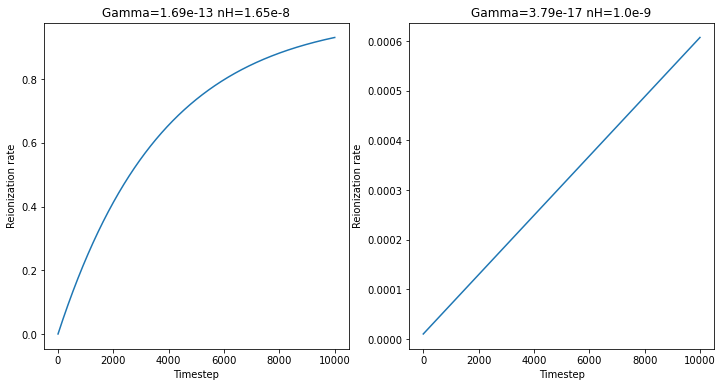

In [207]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].plot(data[0])
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Reionization rate")
ax[0].set_title(f"Gamma={round(params[0, 1] * 1e13, 2)}e-13 nH={round(params[0, 0] * 1e8, 2)}e-8")
ax[1].plot(data[12])
ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("Reionization rate")
ax[1].set_title(f"Gamma={round(params[12, 1] * 1e17, 2)}e-17 nH={round(params[12, 0] * 1e9, 2)}e-9")
plt.show()

In [95]:
timesteps = torch.tensor(u_time).float().view(-1,1)
y = torch.tensor(data).float()

In [96]:
print(y.shape)

torch.Size([2000, 10000])


We concatenate timesteps and physics parameters and apply rescaling for better convergence

Each feature tensor has format (timestep, n, gamma)

In [253]:
x = torch.zeros((2000, 10000, 3)) # n_simulations * n_timesteps * feature_dim
for i, row in enumerate(params):
    row = row * np.array([N_SCALE, GAMMA_SCALE])
    row_2d = np.broadcast_to(row, (10000, 2))
    row_2d = torch.tensor(row_2d).float()
    x[i] = torch.hstack((timesteps * TIMESTEP_SCALE, row_2d))
print(x[0, 0:5, :])

tensor([[0.0000e+00, 1.6522e-02, 1.6896e-02],
        [1.0000e-04, 1.6522e-02, 1.6896e-02],
        [2.0000e-04, 1.6522e-02, 1.6896e-02],
        [3.0000e-04, 1.6522e-02, 1.6896e-02],
        [4.0000e-04, 1.6522e-02, 1.6896e-02]])


In [254]:
model = FCN([3, 32, 32, 32, 32, 1], activation=torch.nn.ELU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=500,)

run = RunAllSimulations('debug_multi_param_4', physics_loss_coef=1e6)

run.data_handler = DataHandlerForAllSimulations(x, y, n_simulations=100)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()

run.train(100)

  0%|          | 0/100 [00:00<?, ?it/s]

Total num of the batches:  100


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


We test the model on 10% of all simulations, for each simulation independently we make prediction for all timesteps and calculate R2 score

In [255]:
pred_best, y_best, pred_worst, y_worst = run.test()

R2 best simulation:  0.9768136
R2 worst simulation:  -785907.6


Let's examine the simulations with the most and the lest accurate predictions to find the cause of enourmous difference in prediction quality

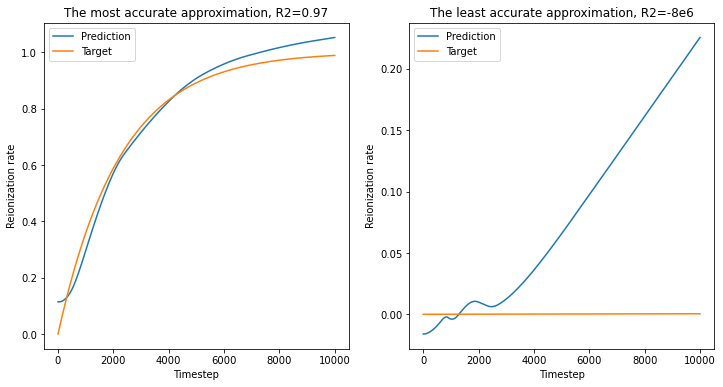

In [259]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax[0].plot(pred_best.detach().numpy(), label="Prediction")
ax[0].plot(y_best.detach().numpy(), label="Target")
ax[0].set_xlabel("Timestep")
ax[0].set_ylabel("Reionization rate")
ax[0].set_title(f"The most accurate approximation, R2=0.97")
ax[0].legend()
ax[1].plot(pred_worst.detach().numpy(), label="Prediction")
ax[1].plot(y_worst.detach().numpy(), label="Target")
ax[1].set_xlabel("Timestep")
ax[1].set_ylabel("Reionization rate")
ax[1].set_title("The least accurate approximation, R2=-8e6")
ax[1].legend()
plt.show()

We see that model performs better in case of expected behaviour of reionization rate: smooth convex function with a relaxation at the end of the time period. The most simulations in the train set look similarly.

The model fails in case of rare behaviour of target function: linear function, slowly increasing without a relaxation. The model doesn't expect small values during the whole process, which results in artifacts(negative values, extremums)